## Installing Neccesary Libraries

In [1]:
# Install kagglehub
!pip install kagglehub --quiet
!pip install wordcloud --quiet

## Data Collection

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import urllib.parse
from wordcloud import WordCloud
from collections import Counter
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
import random

import re
warnings.filterwarnings('ignore')

In [3]:
# Download latest version of the dataset
path = kagglehub.dataset_download("sid321axn/malicious-urls-dataset")

# Check what files are inside
os.listdir(path)

100%|██████████| 16.9M/16.9M [00:00<00:00, 113MB/s] 

Extracting files...


['malicious_phish.csv']

In [4]:
# loading main CSV file
data_path = os.path.join(path, "malicious_phish.csv")
df = pd.read_csv(data_path)
print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


## Exploratory Data Analysis


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB

--- Missing Values ---
url     0
type    0
dtype: int64

--- Label Distribution ---
type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64


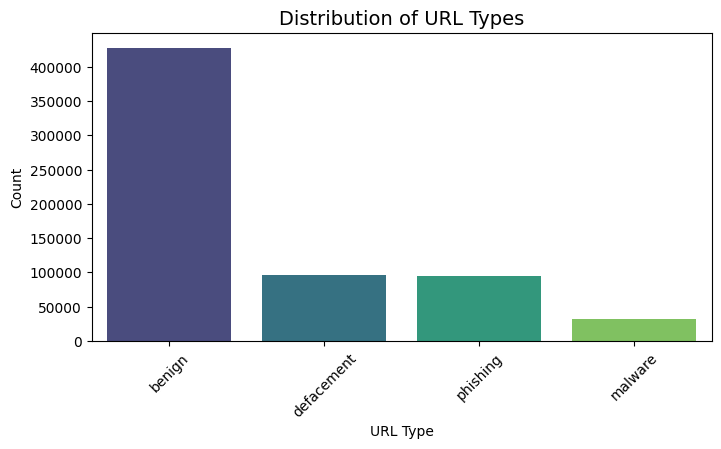

In [5]:
print("\n--- Dataset Info ---")
df.info()

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Label Distribution ---")
print(df['type'].value_counts())

# Visualize label distribution
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='type', order=df['type'].value_counts().index, palette='viridis')
plt.title("Distribution of URL Types", fontsize=14)
plt.xlabel("URL Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


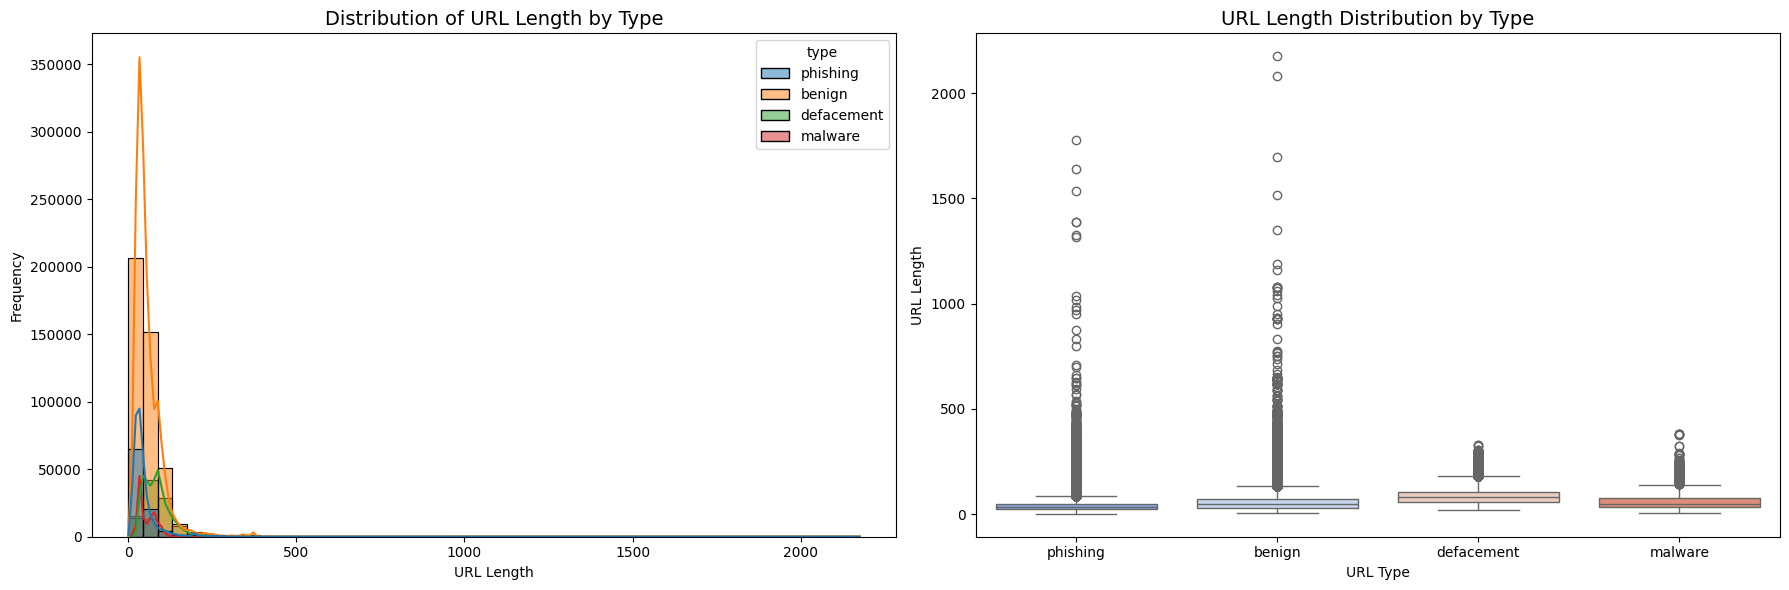

In [6]:
# Compute URL lengths
df['url_length'] = df['url'].apply(len)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram
sns.histplot(data=df, x='url_length', hue='type', bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of URL Length by Type", fontsize=14)
axes[0].set_xlabel("URL Length")
axes[0].set_ylabel("Frequency")

# Boxplot
sns.boxplot(data=df, x='type', y='url_length', palette='coolwarm', ax=axes[1])
axes[1].set_title("URL Length Distribution by Type", fontsize=14)
axes[1].set_xlabel("URL Type")
axes[1].set_ylabel("URL Length")

plt.tight_layout()
plt.show()

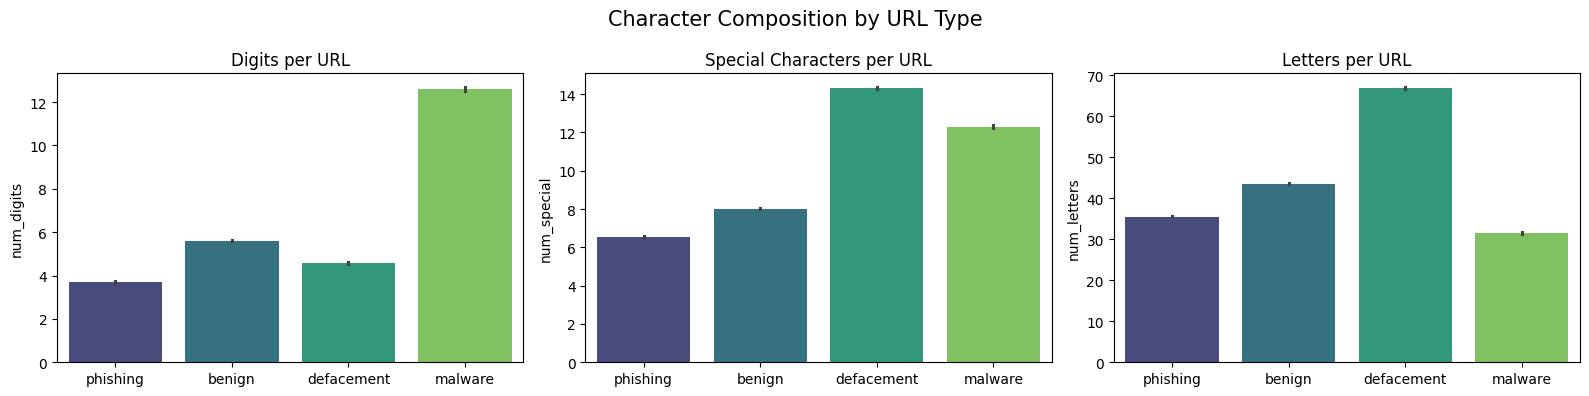

In [7]:
# Compute character composition stats
df['num_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in x))
df['num_special'] = df['url'].apply(lambda x: len(re.findall(r'\W', x)))
df['num_letters'] = df['url'].apply(lambda x: sum(c.isalpha() for c in x))

fig, axes = plt.subplots(1, 3, figsize=(16,4))
sns.barplot(data=df, x='type', y='num_digits', ax=axes[0], palette='viridis')
axes[0].set_title("Digits per URL")
axes[0].set_xlabel("")

sns.barplot(data=df, x='type', y='num_special', ax=axes[1], palette='viridis')
axes[1].set_title("Special Characters per URL")
axes[1].set_xlabel("")

sns.barplot(data=df, x='type', y='num_letters', ax=axes[2], palette='viridis')
axes[2].set_title("Letters per URL")
axes[2].set_xlabel("")

plt.suptitle("Character Composition by URL Type", fontsize=15)
plt.tight_layout()
plt.show()

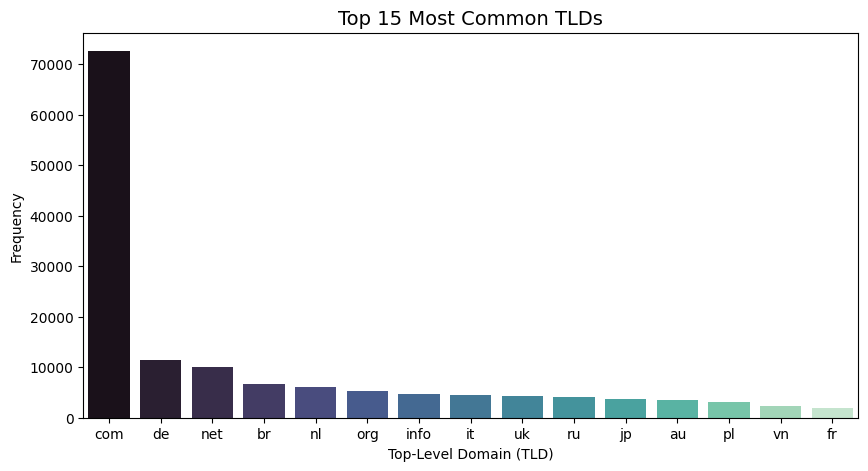

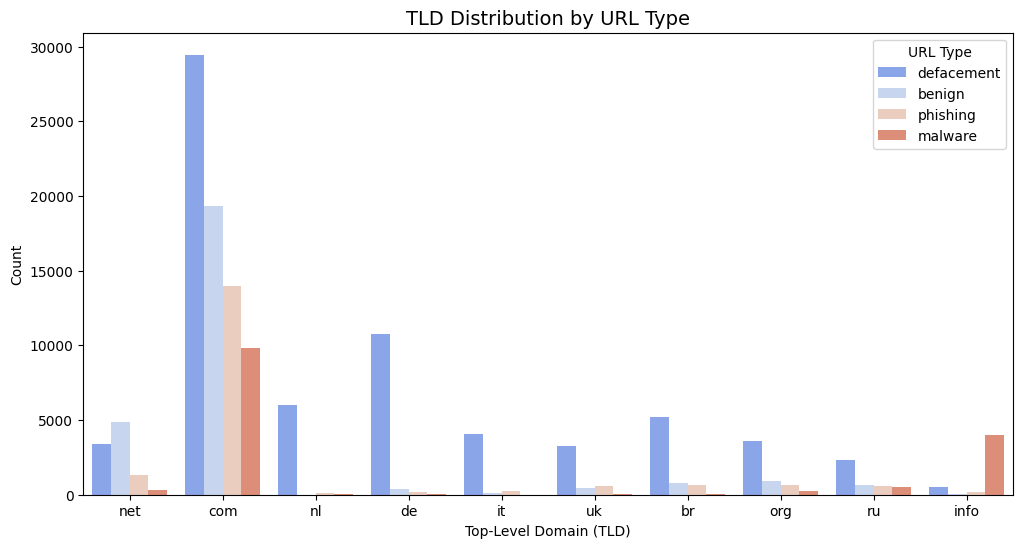

In [8]:
# Extract domain info
def extract_tld(url):
    try:
        hostname = urllib.parse.urlparse(url).hostname
        if hostname:
            return hostname.split('.')[-1]
    except:
        return None
    return None

df['tld'] = df['url'].apply(extract_tld)

# Top 15 TLDs overall
tld_counts = df['tld'].value_counts().head(15)

plt.figure(figsize=(10,5))
sns.barplot(x=tld_counts.index, y=tld_counts.values, palette='mako')
plt.title("Top 15 Most Common TLDs", fontsize=14)
plt.xlabel("Top-Level Domain (TLD)")
plt.ylabel("Frequency")
plt.show()

# TLD distribution by URL type
top_tlds = df['tld'].value_counts().head(10).index
plt.figure(figsize=(12,6))
sns.countplot(data=df[df['tld'].isin(top_tlds)], x='tld', hue='type', palette='coolwarm')
plt.title("TLD Distribution by URL Type", fontsize=14)
plt.xlabel("Top-Level Domain (TLD)")
plt.ylabel("Count")
plt.legend(title="URL Type")
plt.show()

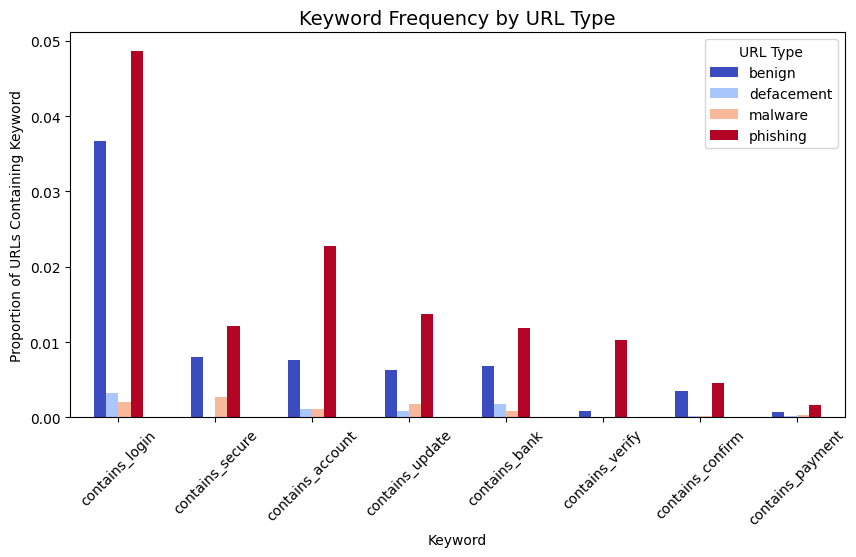

In [9]:
keywords = ['login', 'secure', 'account', 'update', 'bank', 'verify', 'confirm', 'payment']
for key in keywords:
    df[f'contains_{key}'] = df['url'].str.contains(key, case=False, na=False).astype(int)

# Summarize frequency by class
keyword_summary = df.groupby('type')[[f'contains_{k}' for k in keywords]].mean().T

keyword_summary.plot(kind='bar', figsize=(10,5), colormap='coolwarm')
plt.title("Keyword Frequency by URL Type", fontsize=14)
plt.ylabel("Proportion of URLs Containing Keyword")
plt.xlabel("Keyword")
plt.xticks(rotation=45)
plt.legend(title="URL Type")
plt.show()


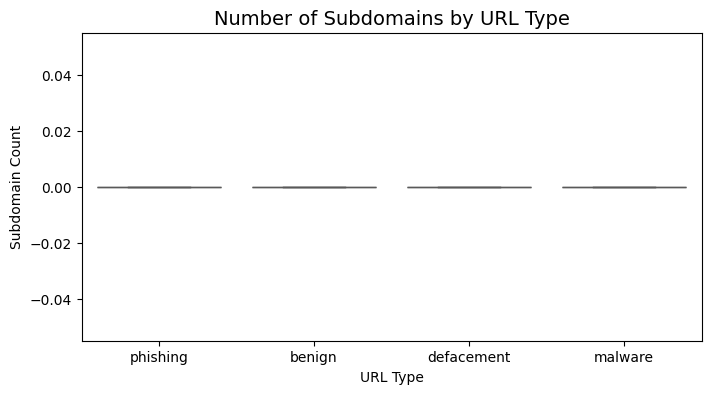

In [10]:
# counting the subdomain in every url
def count_subdomains(url):
    try:
        hostname = urlparse(url).hostname
        if hostname:
            return len(hostname.split('.')) - 2  # exclude domain and TLD
    except:
        return 0
    return 0

df['num_subdomains'] = df['url'].apply(count_subdomains)

plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='type', y='num_subdomains', palette='Spectral')
plt.title("Number of Subdomains by URL Type", fontsize=14)
plt.xlabel("URL Type")
plt.ylabel("Subdomain Count")
plt.show()


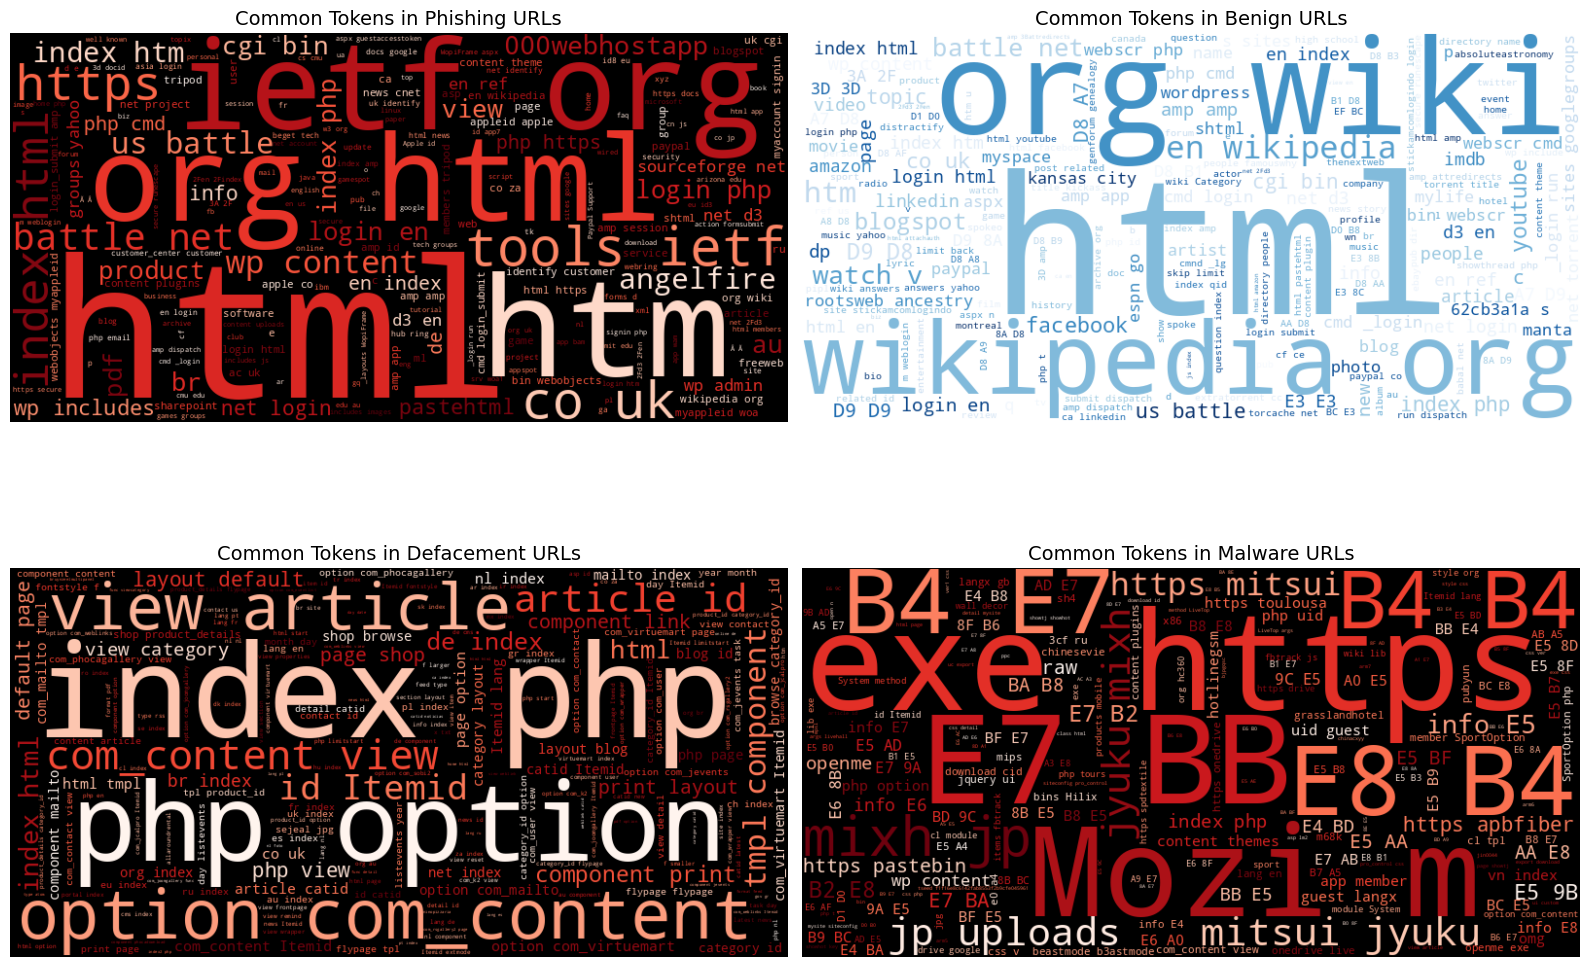

In [11]:
# Separate URLs by type
url_types = df['type'].unique()
wordclouds = {}

for url_type in url_types:
    urls = df[df['type'] == url_type]['url'].str.cat(sep=' ')
    if url_type == 'benign':
        wc = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(urls)
    else:
        wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(urls)
    wordclouds[url_type] = wc

# Display word clouds
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, url_type in enumerate(url_types):
    axes[i].imshow(wordclouds[url_type], interpolation='bilinear')
    axes[i].set_title(f"Common Tokens in {url_type.capitalize()} URLs", fontsize=14)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## FEATURE ENGINEERING AND PREPROCESSING


In [12]:
# Creating Helper Functions

def count_digits(url):
    return sum(c.isdigit() for c in url)

def count_special_chars(url):
    return len(re.findall(r'\W', url))  # non-alphanumeric

def count_letters(url):
    return sum(c.isalpha() for c in url)

def has_https(url):
    return int(url.lower().startswith("https"))

def count_subdomains(url):
    try:
        hostname = urlparse(url).hostname
        if hostname:
            return len(hostname.split('.')) - 2
    except:
        return 0
    return 0

def extract_tld(url):
    try:
        hostname = urlparse(url).hostname
        if hostname:
            return hostname.split('.')[-1]
    except:
        return None
    return None

def path_depth(url):
    try:
        path = urlparse(url).path
        return path.count('/')
    except:
        return 0

def shannon_entropy(s):
    """Entropy measures randomness; higher = more obfuscation."""
    prob = [n_x / len(s) for x, n_x in Counter(s).items()]
    entropy = -sum([p * np.log2(p) for p in prob])
    return entropy

def contains_ip(url):
    """Flag URLs containing IP addresses instead of domains."""
    return int(bool(re.search(r'(\d{1,3}\.){3}\d{1,3}', url)))

def keyword_flag(url, keyword):
    return int(keyword in url.lower())

# ---- Feature Extraction ---- #

def extract_features(df):
    data = pd.DataFrame()
    data['url'] = df['url']
    data['type'] = df['type']

    data['url_length'] = df['url'].apply(len)
    data['num_digits'] = df['url'].apply(count_digits)
    data['num_special'] = df['url'].apply(count_special_chars)
    data['num_letters'] = df['url'].apply(count_letters)
    data['has_https'] = df['url'].apply(has_https)
    data['num_subdomains'] = df['url'].apply(count_subdomains)
    data['path_depth'] = df['url'].apply(path_depth)
    data['entropy'] = df['url'].apply(shannon_entropy)
    data['contains_ip'] = df['url'].apply(contains_ip)
    data['tld'] = df['url'].apply(extract_tld)

    # Keyword flags (based on EDA insights)
    keywords = ['login', 'secure', 'account', 'update', 'bank', 'verify', 'confirm', 'payment']
    for key in keywords:
        data[f'has_{key}'] = df['url'].apply(lambda x: keyword_flag(x, key))

    # Encode TLD frequency (rare domains get higher anomaly score)
    tld_freq = data['tld'].value_counts(normalize=True)
    data['tld_freq'] = data['tld'].map(tld_freq)
    data['rare_tld_flag'] = (data['tld_freq'] < 0.001).astype(int)

    return data

In [13]:
# Apply feature extraction
features_df = extract_features(df)
print("✅ Features extracted successfully!")
print(features_df.head())

✅ Features extracted successfully!
                                                 url        type  url_length  \
0                                   br-icloud.com.br    phishing          16   
1                mp3raid.com/music/krizz_kaliko.html      benign          35   
2                    bopsecrets.org/rexroth/cr/1.htm      benign          31   
3  http://www.garage-pirenne.be/index.php?option=...  defacement          88   
4  http://adventure-nicaragua.net/index.php?optio...  defacement         235   

   num_digits  num_special  num_letters  has_https  num_subdomains  \
0           0            3           13          0               0   
1           1            4           29          0               0   
2           1            5           25          0               0   
3           7           16           63          0               0   
4          22           13          199          0               0   

   path_depth   entropy  ...  has_login has_secure  has_account

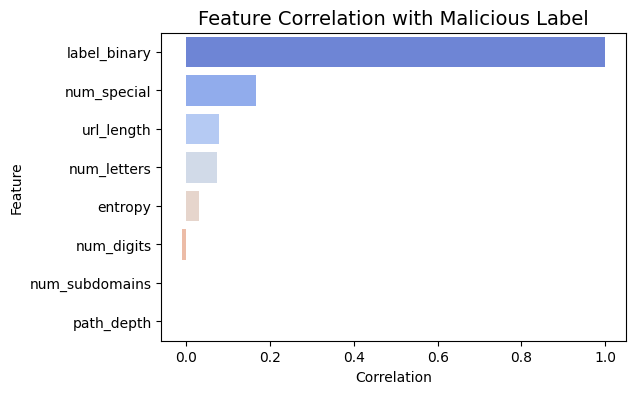

In [14]:
# Simplify type to binary for correlation check (benign=0, malicious=1)
features_df['label_binary'] = features_df['type'].apply(lambda x: 0 if x == 'benign' else 1)

num_features = ['url_length', 'num_digits', 'num_special', 'num_letters',
                'num_subdomains', 'path_depth', 'entropy']

corr = features_df[num_features + ['label_binary']].corr()['label_binary'].sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=corr.values, y=corr.index, palette='coolwarm')
plt.title("Feature Correlation with Malicious Label", fontsize=14)
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()

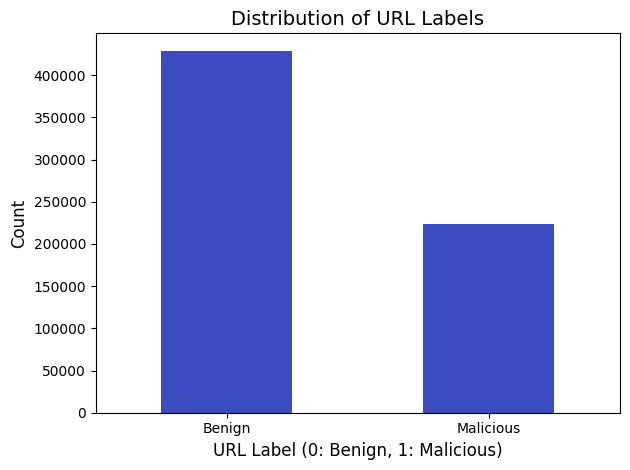

In [15]:
# Create the plot
features_df.label_binary.value_counts().plot(kind='bar', colormap='coolwarm')

# Add title and labels
plt.title('Distribution of URL Labels', fontsize=14)
plt.xlabel('URL Label (0: Benign, 1: Malicious)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Benign', 'Malicious'], rotation=0) # Customize x-axis labels
plt.tight_layout()
plt.show()


In [16]:
# checking for null values
features_df.isnull().sum()

,0
url,0
type,0
url_length,0
num_digits,0
num_special,0
num_letters,0
has_https,0
num_subdomains,0
path_depth,0
entropy,0


##  HANDLE CLASS IMBALANCE & DROP HIGH-MISSING COLUMNS

In [17]:
# Drop columns with excessive missing values
cols_to_drop = ['tld', 'tld_freq']
features_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print(f"🗑️ Dropped columns: {cols_to_drop}")
print("Remaining columns:", features_df.columns.tolist())

# Separate majority and minority classes
majority_df = features_df[features_df['label_binary'] == 0]
minority_df = features_df[features_df['label_binary'] == 1]

print(f"Before downsampling -> Benign: {len(majority_df)}, Malicious: {len(minority_df)}")

# Downsample majority to match minority
majority_downsampled = resample(
    majority_df,
    replace=False,
    n_samples=len(minority_df),
    random_state=42
)

# Combine back into one balanced DataFrame
balanced_df = pd.concat([majority_downsampled, minority_df]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ After downsampling -> Benign: {(balanced_df['label_binary']==0).sum()}, Malicious: {(balanced_df['label_binary']==1).sum()}")
print(f"Total samples: {len(balanced_df)}")

🗑️ Dropped columns: ['tld', 'tld_freq']
Remaining columns: ['url', 'type', 'url_length', 'num_digits', 'num_special', 'num_letters', 'has_https', 'num_subdomains', 'path_depth', 'entropy', 'contains_ip', 'has_login', 'has_secure', 'has_account', 'has_update', 'has_bank', 'has_verify', 'has_confirm', 'has_payment', 'rare_tld_flag', 'label_binary']
Before downsampling -> Benign: 428103, Malicious: 223088
✅ After downsampling -> Benign: 223088, Malicious: 223088
Total samples: 446176


In [18]:
# select feature columns (excluding dropped ones)
feature_cols = [
    'url_length', 'num_digits', 'num_special', 'num_letters',
    'has_https', 'num_subdomains', 'path_depth', 'entropy',
    'contains_ip', 'rare_tld_flag'
] + [f'has_{k}' for k in ['login','secure','account','update','bank','verify','confirm','payment']]

X = balanced_df[feature_cols]
y = balanced_df['label_binary']

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Feature matrix and labels ready for modeling.")
print(f"Feature matrix shape: {X_scaled.shape}")

✅ Feature matrix and labels ready for modeling.
Feature matrix shape: (446176, 18)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("✅ Data split into training and testing sets.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

✅ Data split into training and testing sets.
X_train shape: (356940, 18)
X_test shape: (89236, 18)
y_train shape: (356940,)
y_test shape: (89236,)


## Define Models to be Trained

In [21]:
# Instantiate classifiers
lr_model = LogisticRegression(random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
sgd_model = SGDClassifier(random_state=42)

# Create a list of models
models = [
    ('Logistic Regression', lr_model),
    ('Decision Tree', dt_model),
    ('Random Forest', rf_model)
]

print("✅ Classifiers instantiated and added to a list.")

✅ Classifiers instantiated and added to a list.


In [22]:
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    """
    Trains a model, evaluates it, and plots the confusion matrix.

    Args:
        model: The machine learning model object.
        model_name (str): The name of the model.
        X_train: Training features.
        y_train: Training labels.
        X_test: Testing features.
        y_test: Testing labels.
    """
    print(f"\n--- Training and Evaluating {model_name} ---")

    # Train the model
    model.fit(X_train, y_train)
    print("✅ Model trained successfully.")

    # Make predictions
    y_pred = model.predict(X_test)
    print("✅ Predictions made successfully.")

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"📊 Evaluation Metrics for {model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.title(f"Confusion Matrix for {model_name}", fontsize=14)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

print("✅ `train_and_evaluate_model` function defined.")

✅ `train_and_evaluate_model` function defined.



--- Training and Evaluating Logistic Regression ---
✅ Model trained successfully.
✅ Predictions made successfully.
📊 Evaluation Metrics for Logistic Regression:
  Accuracy: 0.6879
  Precision: 0.7002
  Recall: 0.6879
  F1-score: 0.6833


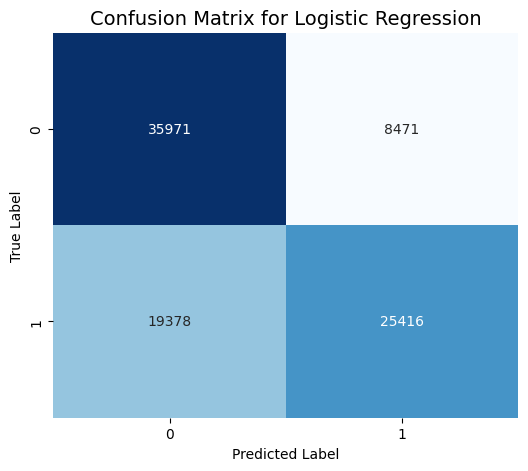


--- Training and Evaluating Decision Tree ---
✅ Model trained successfully.
✅ Predictions made successfully.
📊 Evaluation Metrics for Decision Tree:
  Accuracy: 0.8029
  Precision: 0.8033
  Recall: 0.8029
  F1-score: 0.8028


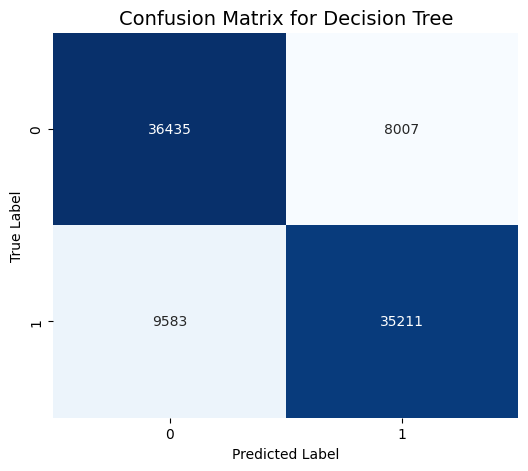


--- Training and Evaluating Random Forest ---
✅ Model trained successfully.
✅ Predictions made successfully.
📊 Evaluation Metrics for Random Forest:
  Accuracy: 0.8260
  Precision: 0.8265
  Recall: 0.8260
  F1-score: 0.8260


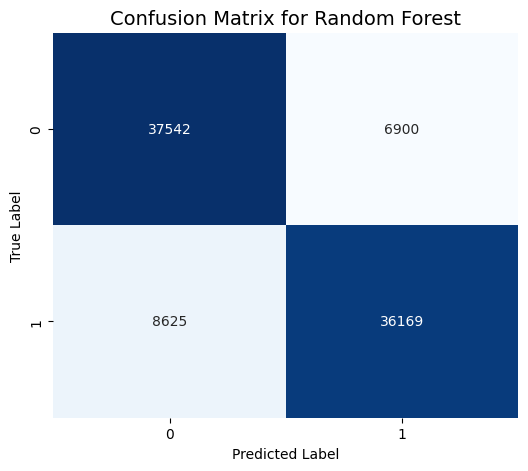

In [23]:
# Iterate through the list of models and train/evaluate each one
for model_name, model in models:
    train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test)

## Adversarial data augmentation

In [24]:
def homoglyph_substitute(url):
    mapping = {'a': ['@', 'a'], 'o': ['0', 'o'], 'i': ['1', 'i'], 'e': ['3', 'e'], 's': ['$', 's']}
    new_url = ''
    for c in url:
        if c.lower() in mapping and random.random() < 0.3:
            new_url += random.choice(mapping[c.lower()])
        else:
            new_url += c
    return new_url

def add_subdomain(url):
    try:
        parsed = urlparse(url)
        hostname = parsed.hostname or ''
        fake_prefix = random.choice(['login', 'secure', 'auth', 'update'])
        new_host = f"{fake_prefix}.{hostname}"
        return parsed._replace(netloc=new_host).geturl()
    except:
        return url

def generate_adversarial_samples(df, n_multiplier=0.5):
    """Generate adversarial variants of malicious URLs."""
    mal_df = df[df['label_binary'] == 1]
    n_new = int(len(mal_df) * n_multiplier)
    adv_urls = []
    for i in range(n_new):
        url = random.choice(mal_df['url'].values)
        u = url
        if random.random() < 0.5:
            u = homoglyph_substitute(u)
        if random.random() < 0.3:
            u = add_subdomain(u)
        adv_urls.append(u)
    adv_df = pd.DataFrame({'url': adv_urls, 'label_binary': 1})
    return pd.concat([df, adv_df], ignore_index=True)


In [25]:
augmented_df = generate_adversarial_samples(balanced_df, n_multiplier=0.5)
print(f"✅ Augmented dataset size: {len(augmented_df)} (includes adversarial samples)")


✅ Augmented dataset size: 557720 (includes adversarial samples)


In [26]:
adv_features_df = extract_features(augmented_df)
adv_features_df.drop(columns=['tld', 'tld_freq'], errors='ignore', inplace=True)
adv_features_df


,url,type,url_length,num_digits,num_special,num_letters,has_https,num_subdomains,path_depth,entropy,contains_ip,has_login,has_secure,has_account,has_update,has_bank,has_verify,has_confirm,has_payment,rare_tld_flag
0,asamcgill.com/,benign,14,0,2,12,0,0,0,3.235926,0,0,0,0,0,0,0,0,0,0
1,http://www.bogdanobradovic.com/t3-assets/js/20...,phishing,63,5,12,46,0,0,0,4.393715,0,0,0,0,0,0,0,0,0,0
2,http://noticias.uol.com.br/tabloide/ultimas-no...,benign,153,8,27,118,0,0,0,4.371984,0,0,0,0,0,0,0,0,0,0
3,manta.com/c/mt4crnc/sue-kelly-dermatology-llc,benign,45,1,7,37,0,0,0,4.030773,0,0,0,0,0,0,0,0,0,0
4,ofmenandangels.blogspot.com/2009/02/vince-azzo...,benign,56,6,7,43,0,0,0,4.483445,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557715,developers.slashdot.org/article.pl?sid=03/03/1...,NaN,55,13,9,33,0,0,0,4.403643,0,0,0,0,0,0,0,0,0,0
557716,http://www.applausemovie.com/g@ll3ry.1,NaN,38,2,8,28,0,0,0,4.359127,0,0,0,0,0,0,0,0,0,0
557717,http://www.skubawerk.de/ru/contact,NaN,34,0,7,27,0,0,0,3.969816,0,0,0,0,0,0,0,0,0,0
557718,http://pjhku.com/plugin.php?id=levsign&m=2&fh=...,NaN,71,8,16,47,0,0,0,4.720760,0,0,0,0,0,0,0,0,0,0


In [27]:
X_adv = adv_features_df[feature_cols]
y_adv = augmented_df['label_binary'] # Get label_binary from the augmented_df

X_train, X_val, y_train, y_val = train_test_split(X_adv, y_adv, test_size=0.2, stratify=y_adv, random_state=42)


## Evaluate Individual Models after Adversarial Training


--- Evaluating Logistic Regression on Validation Set (after Adversarial Training) ---
📊 Evaluation Metrics for Logistic Regression:
  Accuracy: 0.4000
  Precision: 0.1600
  Recall: 0.4000
  F1-score: 0.2286


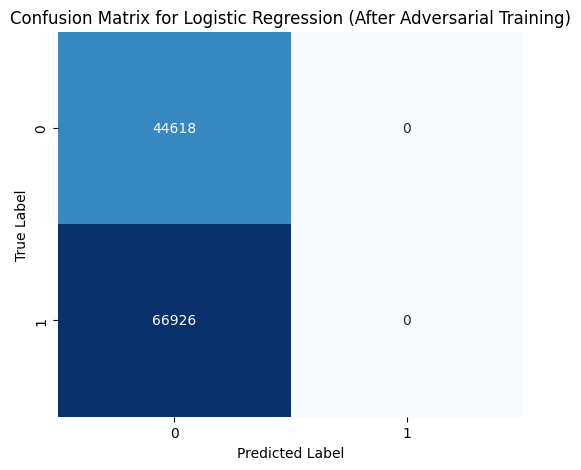


--- Evaluating Decision Tree on Validation Set (after Adversarial Training) ---
📊 Evaluation Metrics for Decision Tree:
  Accuracy: 0.5711
  Precision: 0.4563
  Recall: 0.5711
  F1-score: 0.4591


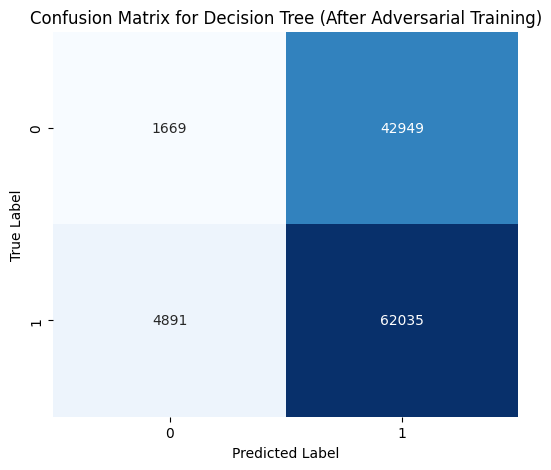


--- Evaluating Random Forest on Validation Set (after Adversarial Training) ---
📊 Evaluation Metrics for Random Forest:
  Accuracy: 0.5845
  Precision: 0.4989
  Recall: 0.5845
  F1-score: 0.4713


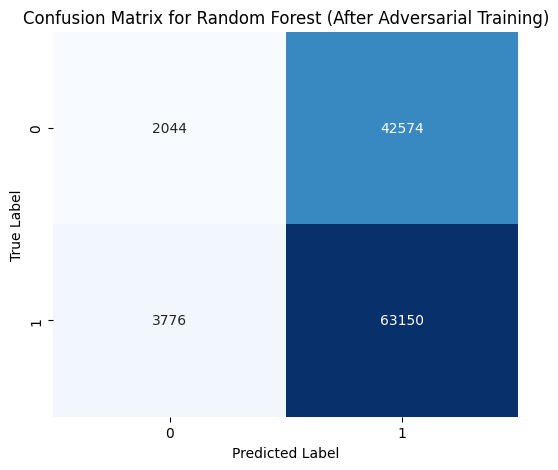

In [28]:
def evaluate_model_after_adv_training(model, model_name, X_val, y_val):
    """
    Evaluates a model trained on augmented data and plots the confusion matrix.

    Args:
        model: The machine learning model object.
        model_name (str): The name of the model.
        X_val: Validation features (adversarial test set).
        y_val: Validation labels.
    """
    print(f"\n--- Evaluating {model_name} on Validation Set (after Adversarial Training) ---")

    # Make predictions
    y_pred = model.predict(X_val)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')

    print(f"📊 Evaluation Metrics for {model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=y_val.unique(), yticklabels=y_val.unique())
    plt.title(f"Confusion Matrix for {model_name} (After Adversarial Training)", fontsize=12)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


# Evaluate each model on the validation set after adversarial training
for model_name, model in models:
    evaluate_model_after_adv_training(model, model_name, X_val, y_val)


In [29]:
# Create a list of (name, model) tuples for the ensemble
ensemble_models = [
    ('Logistic Regression', lr_model),
    ('Decision Tree', dt_model),
    ('Random Forest', rf_model)
]

# Create the VotingClassifier
ensemble_model = VotingClassifier(estimators=ensemble_models, voting='soft')

print("✅ Ensemble model created.")

✅ Ensemble model created.


✅ Ensemble model trained successfully.
=== Clean Test Set ===
              precision    recall  f1-score   support

           0       0.80      0.76      0.78     44618
           1       0.84      0.87      0.86     66926

    accuracy                           0.83    111544
   macro avg       0.82      0.81      0.82    111544
weighted avg       0.83      0.83      0.83    111544

ROC-AUC: 0.8149802761676371

=== Adversarial (Zero-Day) Test Set ===
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5041
           1       0.92      0.91      0.92      7438

    accuracy                           0.90     12479
   macro avg       0.90      0.90      0.90     12479
weighted avg       0.90      0.90      0.90     12479

ROC-AUC: 0.9000633231806793


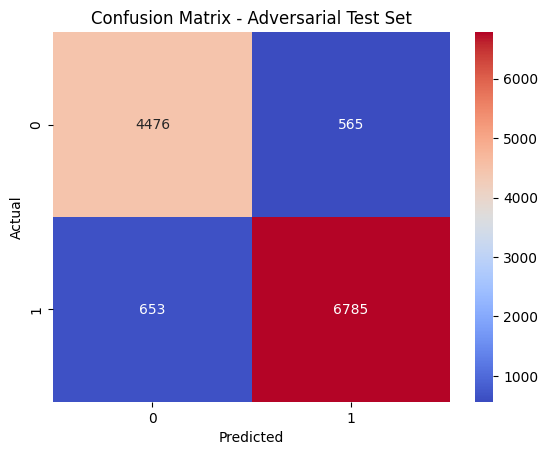

In [30]:
# Train the ensemble model
ensemble_model.fit(X_train, y_train)
print("✅ Ensemble model trained successfully.")


# Evaluate on clean test set
y_pred_clean = ensemble_model.predict(X_val)
print("=== Clean Test Set ===")
print(classification_report(y_val, y_pred_clean))
print("ROC-AUC:", roc_auc_score(y_val, y_pred_clean))

# Evaluate on adversarial test set (freshly perturbed)
adv_test_df = generate_adversarial_samples(balanced_df.sample(10000, random_state=42))
adv_test_features = extract_features(adv_test_df)
adv_test_features.drop(columns=['tld', 'tld_freq'], errors='ignore', inplace=True)
X_adv_test = adv_test_features[feature_cols]
y_adv_test = adv_test_df['label_binary'] # Get label_binary from adv_test_df

y_pred_adv = ensemble_model.predict(X_adv_test)
print("\n=== Adversarial (Zero-Day) Test Set ===")
print(classification_report(y_adv_test, y_pred_adv))
print("ROC-AUC:", roc_auc_score(y_adv_test, y_pred_adv))

# Confusion matrix
cm = confusion_matrix(y_adv_test, y_pred_adv)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix - Adversarial Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

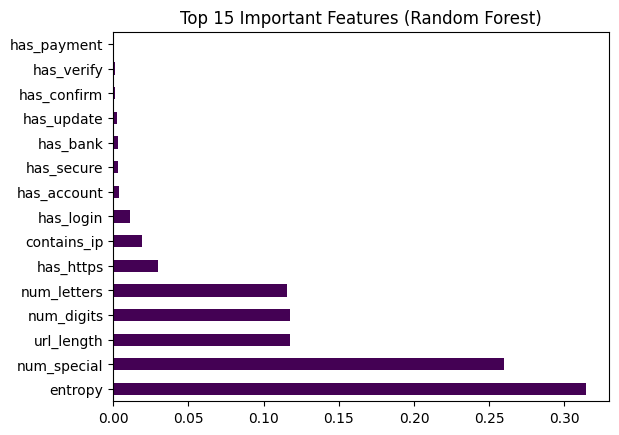

In [31]:
# Calculate feature importances from one of the base models (e.g., Random Forest)
# Note: Feature importances are not directly available from the VotingClassifier itself.
feature_importances = pd.Series(rf_model.feature_importances_, index=feature_cols)
feature_importances.nlargest(15).plot(kind='barh', colormap='viridis')
plt.title("Top 15 Important Features (Random Forest)")
plt.show()

In [32]:
X_train.columns

Index(['url_length', 'num_digits', 'num_special', 'num_letters', 'has_https',
       'num_subdomains', 'path_depth', 'entropy', 'contains_ip',
       'rare_tld_flag', 'has_login', 'has_secure', 'has_account', 'has_update',
       'has_bank', 'has_verify', 'has_confirm', 'has_payment'],
      dtype='object')